# #Atom Maker

Goal: 

Given a material with permitivity ϵ and a given free-space wavelength λ. Determine the phase difference ϕ for an incoming plane wave that an incoming plane wave picks up between the ends of the posts. Do this for pillars with square cross-section of a given height h and varying side D so that what results at the end are two functions ϕ(R) and T(R).

Assume that the posts are placed in a hexagonal lattice.

Since the posts have cylindrical symmetry and the only normal incidence is considered, this scenario produces atoms that are insensitive to polarization (at least in the periodic-atom approximation).

I will base this on the approach provided in the meta-optic designer tool, here I will simply implement calling the script that they provide for this purpose and analyze the resulting data. Refer to the metaoptic designer documentation, section "B.1. General RSoft CAD Nano-Atom template".

As a point of comparison use the data computed of TiO2 as found in the .dat files contained in the folder 

C:\Synopsys\PhotonicSolutions\2022.09\RSoft\examples\MetaOptic\bsdfs\TiO2_square_nanolib_normal_bsdf_data\

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import rspie as rs
from matplotlib import pyplot as plt
import cmasher as cm
import os

# #TiO2 Pillars on a SiO2 substrate

In [2]:
fills = np.linspace(0, 1, 41)

overlap_magnitudes = []
overlap_phases     = []
config = {
    'Period': 0.4,
    'free_space_wavelength': 0.46,
    'PillarIndex':    2.7878,
    'SubstrateIndex': 1.4648,
    'Aspect': 1,
    'Angle':  0,
    'prefix': 'nanosim',
    'Har': 8
}
pillar_widths = fills * config['Period']
original_pillar_widths = np.linspace(0, 1, 21) * config['Period']

for fill in fills:
    simulscript = 'nanolib_rectangular_template.ind'
    config['Fill'] = fill
    omag, ophase = rs.rectangular_meta_atom(config, simulscript, hide=True, cleanup=True)
    overlap_magnitudes.append(omag)
    overlap_phases.append(ophase)
overlap_magnitudes = np.array(overlap_magnitudes)
overlap_phases = np.array(overlap_phases)
rs.send_message('finished!')
    

'{"status":1,"request":"09bf3975-d64a-4dd3-bd3b-718e475e167b"}'

In [3]:
%config InlineBackend.figure_format='retina'

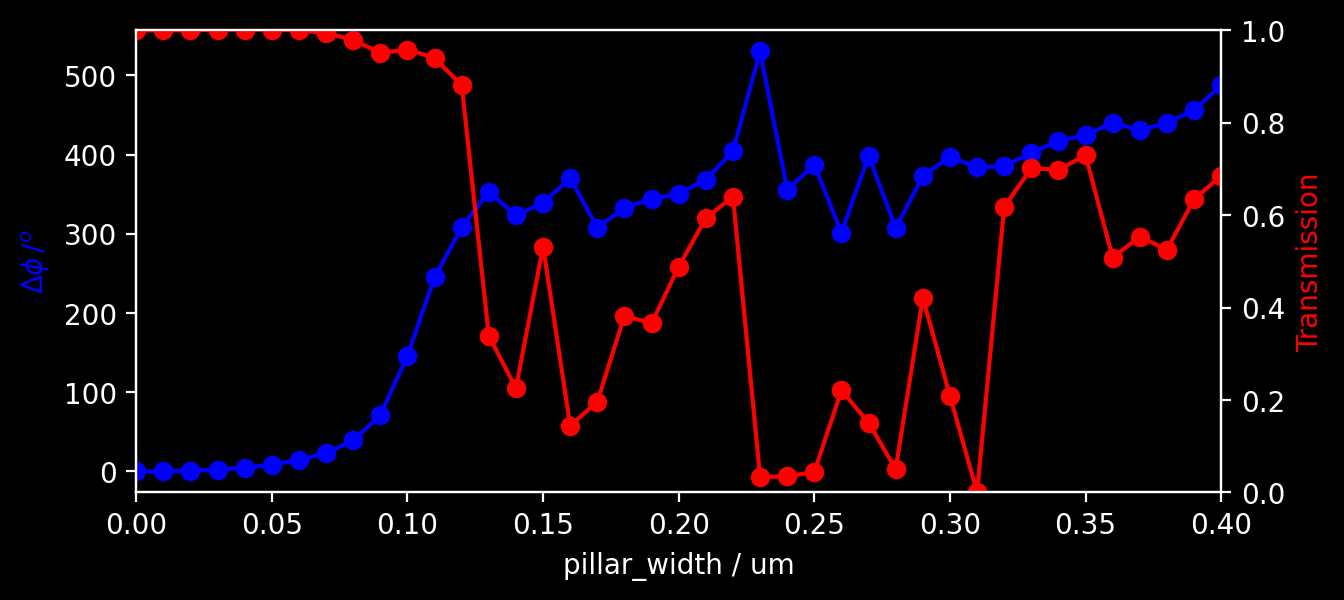

In [4]:
overlap_phases = np.unwrap(overlap_phases - overlap_phases[0], period=360)
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(pillar_widths, overlap_phases,'ob-')
ax.set_xlabel('pillar_width / um')
ax.set_ylabel('$\Delta \phi\,/ {}^o$', color='b')
ax1 = ax.twinx()
ax1.plot(pillar_widths, overlap_magnitudes**2,'or-')
ax1.set_ylabel('Transmission',color='r')
ax1.set_ylim(0,1)
ax.set_xlim(0, pillar_widths[-1])
plt.show()

Synopsys provides a tool to generate nano-atom databases, the data being saved in BSDF data files. Let's compare what we got with what they've provided in the documentation. It takes some detective work to figure out which number to take from there.

In [8]:
tio2folder = r'C:\Synopsys\PhotonicSolutions\2022.09\RSoft\examples\MetaOptic\bsdfs\TiO2_square_nanolib_normal_bsdf_data'
dat_files = [f for f in os.listdir(tio2folder) if f.endswith('.dat')]
dat_files = sorted(dat_files, key=lambda x: float(x.split('_')[4]))
dat_data = []
for dat_file in dat_files:
    file_txt = open(os.path.join(tio2folder, dat_file), 'r').read()
    data_block = file_txt.split('\n')[21:21+8]
    data_block = file_txt.split('\n')[111:111+8]
    parsed_bsdf = []
    for line in data_block:
        nums = [float(x) for x in line.split(' ')]
        parsed_bsdf.append(nums[1::2])
    parsed_bsdf = np.array(parsed_bsdf)
    dat_data.append(parsed_bsdf)
dat_data = np.array(dat_data)

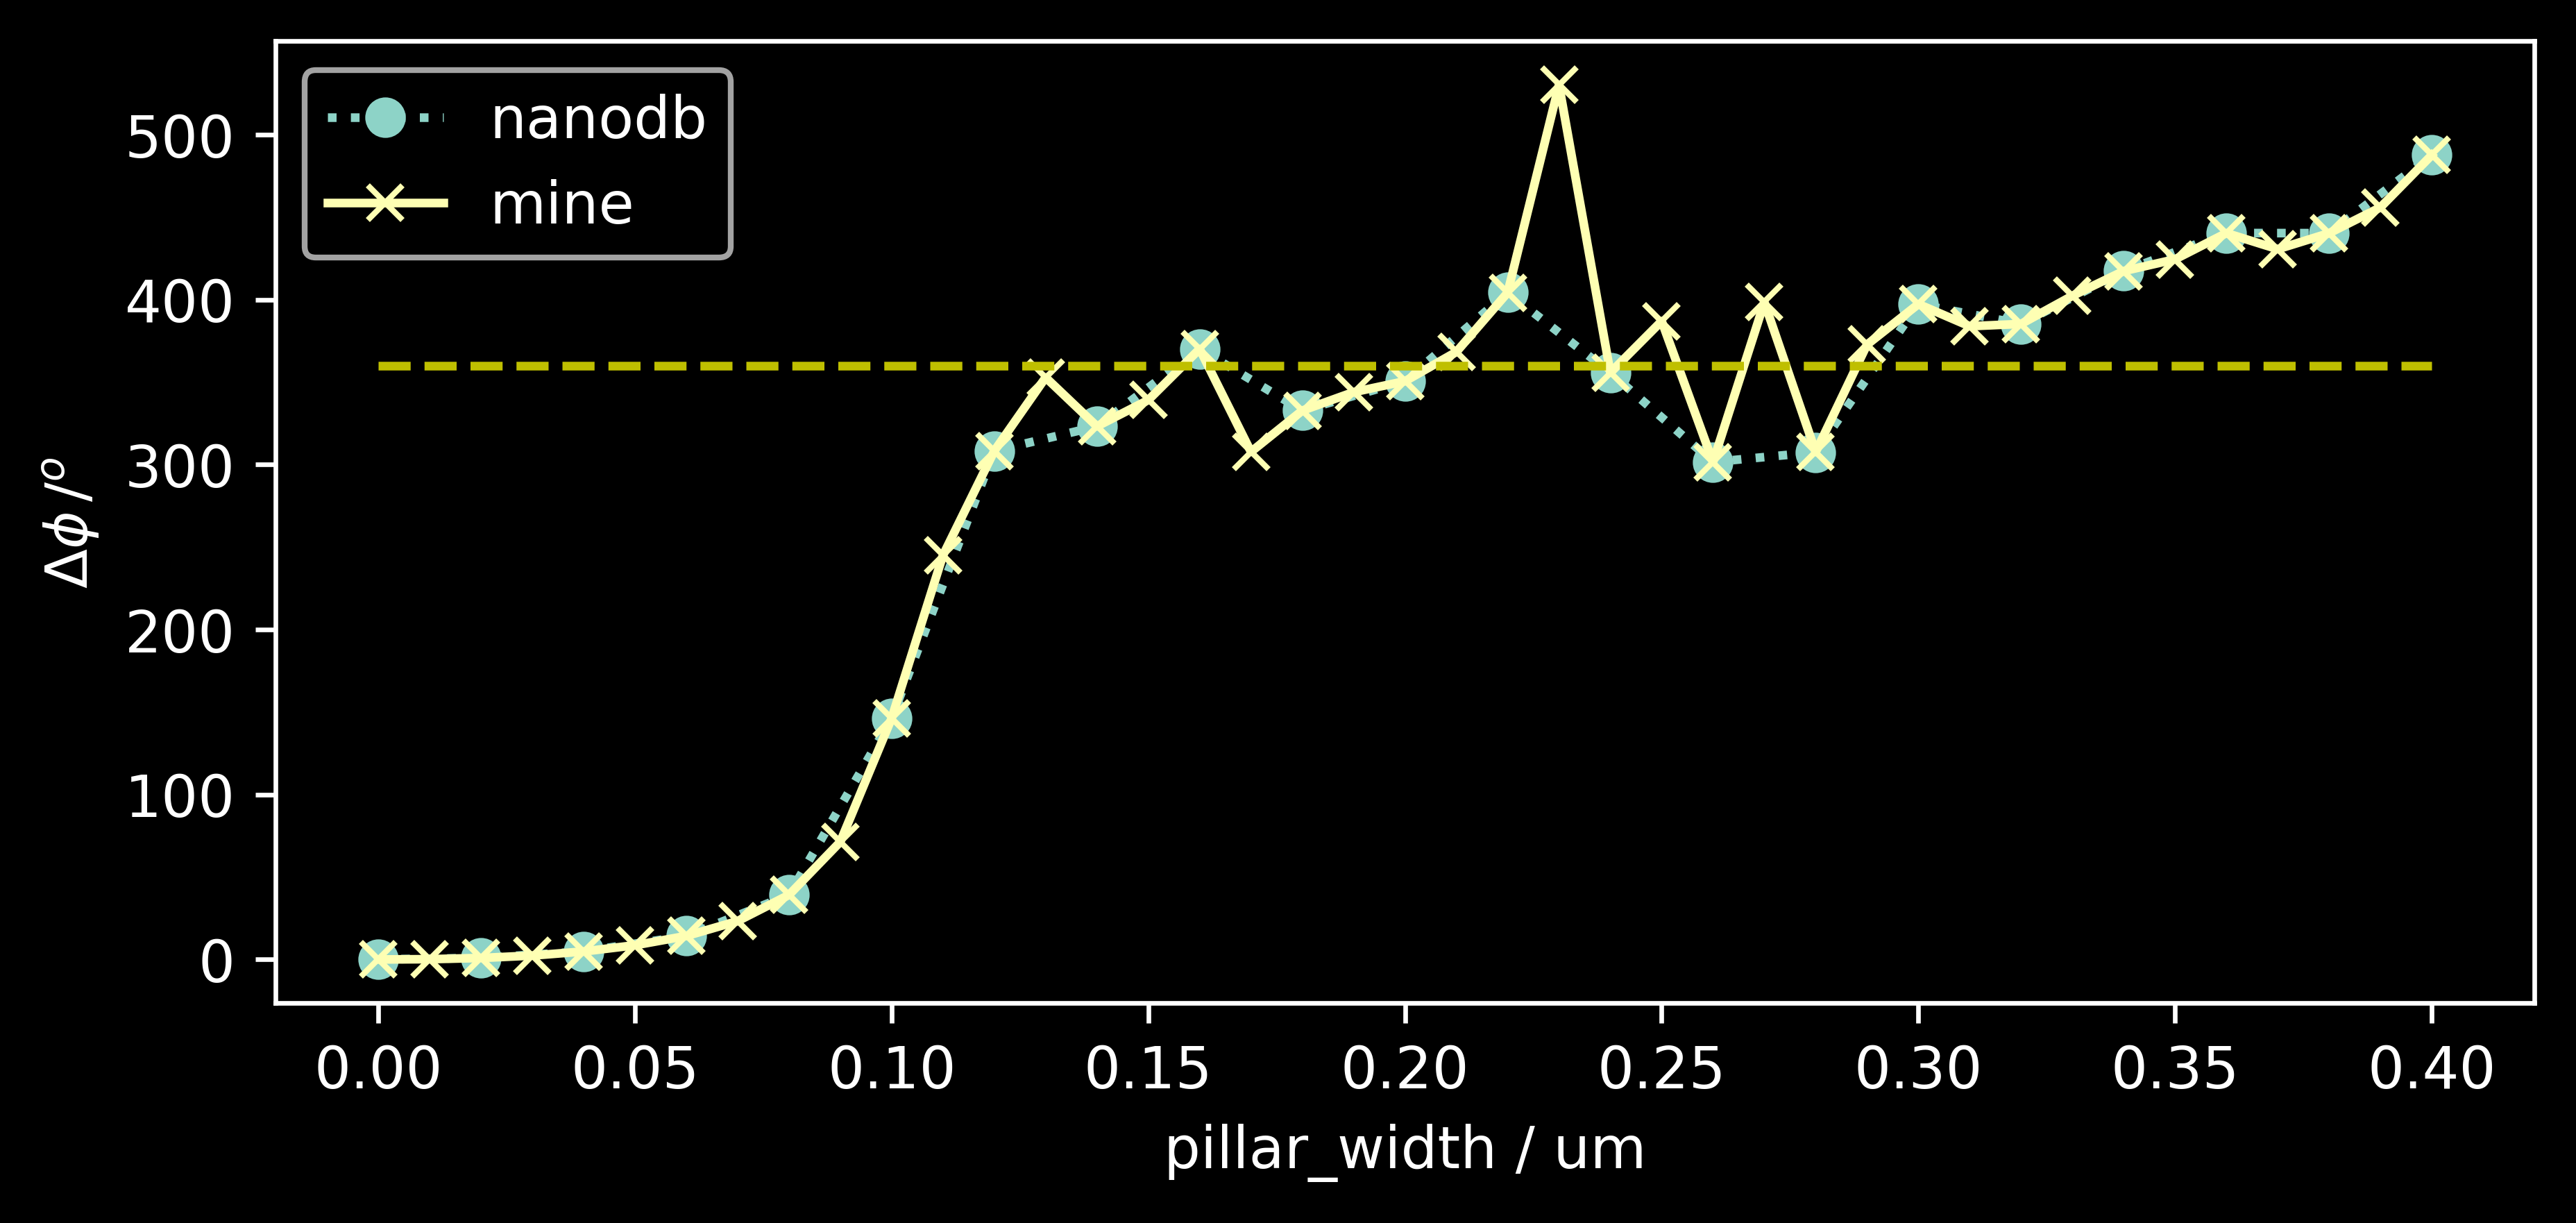

In [45]:
plt.figure(figsize=(7,3))
for idx in [1]:
    datum = dat_data[:,idx,4]
    plt.plot(original_pillar_widths, np.unwrap(datum - datum[0], period=360), 'o:',label='nanodb')
plt.plot(pillar_widths, np.unwrap(overlap_phases - overlap_phases[0], period=360),'x-', label='mine')
plt.plot([pillar_widths[0], pillar_widths[-1]], [360,360], 'y--')
plt.xlabel('pillar_width / um')
plt.ylabel('$\Delta \phi\,/ {}^o$')
plt.legend()
plt.show()